#Data Driven Reactor Stability Forecasting Using Long Short-Term Memory on Recurent Neural Network

---

The goal of this program is to predict the reactor stability by neural network and data driven method. Since the neutron flux over time shouldn't be increase dramatically by order of exp the Reactor Period should be kept at near infinite number (in the case of this simulation max.measurement.value=9999)

The Transient Reactor Parameter is taken by simulating the reactor operation with PcTran ABWR Simulator (http://www.microsimtech.com/abwr/). Data obtained by a single simulation of an initial condition. Data provided in  time series multivariate datasets with 91 features and 301 timesteps.

LSTM was chosen because of its robustness in handling recurring data and predicting certain result from many features. To summon the LSTM module, keras API should be used. Keras is an API for deep learning problem solving (https://keras.io).

##*Update*:

*This solution to search the best prediction model is unavailable due to non-convergent input. This problem caused by Sklearn.Preprocessing.Scaler was failed to scale the fitted data. Thera are still so many scaled features value with >1 variance.*

*Further data preprocessing such as target value shifting and re-evaluation of lookback method should be revised*

#Initializing Module and datasets




1.   **Initialize module and API**

---




In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams
from matplotlib import pyplot as plt
no
import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)

from sklearn.model_selection import train_test_split

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

2.   **Upload Datasets**

---



In [ ]:
from google.colab import files
uploaded = files.upload()
import io

3.   **Datasets Overview**

---



In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['ABWR1_test.csv']))
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 93 columns):
TIME     301 non-null int64
NTFX     301 non-null float64
PFCT     301 non-null float64
ASHX     301 non-null float64
FWFL     301 non-null float64
VSPR     301 non-null float64
TBPR     301 non-null float64
RVFL     301 non-null int64
BPFL     301 non-null int64
TBFL     301 non-null float64
LVIN     301 non-null float64
COFL     301 non-null float64
PMPF     301 non-null int64
VDRK     301 non-null float64
DPRK     301 non-null float64
SCRK     301 non-null float64
TLRK     301 non-null float64
BORK     301 non-null int64
VOID     301 non-null float64
LEV      301 non-null float64
LCOR     301 non-null float64
LDW      301 non-null float64
LWW      301 non-null float64
TOTM     301 non-null float64
UNC      301 non-null int64
TAVG     301 non-null float64
TSAT     301 non-null float64
TFSB     301 non-null float64
TFPK     301 non-null float64
TF       301 non-null float64
TPCT   

,TIME,NTFX,PFCT,ASHX,FWFL,VSPR,TBPR,RVFL,BPFL,TBFL,LVIN,COFL,PMPF,VDRK,DPRK,SCRK,TLRK,BORK,VOID,LEV,LCOR,LDW,LWW,TOTM,UNC,TAVG,TSAT,TFSB,TFPK,TF,TPCT,TDW,TDWU,TWW,TWWG,FRCL,MH2,CNH2,WSTM,WMFW,...,WHPI,WRIC,WBK,WCLK,DCPR,WVTG,WVTA,WLPI,ESDC,TBIJ,HBK,RC131,RC87,WW131,WW87,DW131,DW87,RMUDW,RMLDW,RMWW,RMSL,RMTB,STTBI,STTBG,STRBI,STRBG,DTHY,DTHYI,DWB,DTHL,DTHLI,DWBL,DWBLI,DWBI,TFW,TSCM,VSTF,CPS,PRD,GLD
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.0,301.0,301.000000,301.000000,301.000000,301.0,301.000000,301.000000,301.000000,301.000000,301.0,301.000000,301.000000,301.000000,3.010000e+02,3.010000e+02,301.000000,301.0,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,3.010000e+02,3.010000e+02,301.0,3.010000e+02,301.0,301.0,301.0,301.000000,301.000000,...,301.0,301.0,301.0,301.0,301.0,301.0,301.0,301.0,301.0,3.010000e+02,301.000000,301.000000,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,301.000000,301.000000,3.010000e+02,301.000000,3.010000e+02,3.010000e+02,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,3.010000e+02,3.010000e+02,301.000000
mean,150.000000,49.973976,49.805021,50.056057,50.583266,-35.275892,-0.555302,0.0,0.0,50.305241,29.975488,50.217888,50.0,0.050584,0.013064,-0.069286,-0.005638,0.0,40.707110,147.975488,209.036152,3.280731e-02,2.296560e+01,663.855703,0.0,535.776232,549.287388,882.829000,882.829000,882.829000,535.776232,1.346000e+02,1.346000e+02,95.0,1.094000e+02,0.0,0.0,0.0,2479.672547,2493.377134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.494331e+01,547.554155,25.482367,3.631137e+03,1.272890e-06,6.218790e-05,1.272890e-06,6.218790e-05,2.200000e+00,1.100000e+00,3.300000e+00,1.368631,2.761876,5.341438e-03,25793.253555,1.524430e-06,5.133551e-02,4.167541,0.180084,3.613035,1.218204,0.052640,1.056118,0.045516,0.155713,465.747508,13.468670,50.158231,4.982643e+07,-1.503672e+05,656.404043
std,87.035433,1.917638,1.810353,1.805233,1.635223,3.037335,2.278434,0.0,0.0,2.548795,0.455878,0.058048,0.0,0.061125,0.054210,0.125081,0.011636,0.0,0.527282,0.455878,0.443075,4.170269e-17,1.316693e-13,1.445251,0.0,0.780613,0.410533,12.636314,12.636314,12.636314,0.780613,7.401950e-13,7.401950e-13,0.0,7.686641e-13,0.0,0.0,0.0,125.636545,80.604258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.138762e-13,19.304392,388.518118,6.037996e+04,4.878550e-21,9.502567e-20,4.878550e-21,9.502567e-20,1.023106e-14,3.113801e-15,6.227602e-15,0.075398,0.173773,3.920718e-02,9460.270625,2.121109e-21,1.737612e-16,0.491312,0.102182,0.434394,0.143614,0.029868,0.126977,0.025829,0.088364,21.729919,1.023663,3.845496,3.446300e+06,5.815812e+05,50.324730
min,0.000000,44.410603,44.438393,44.683769,45.366711,-40.672363,-3.353516,0.0,0.0,44.250011,29.242752,49.988880,50.0,0.000000,-0.020464,-0.432348,-0.024811,0.0,39.121140,147.242752,207.929901,3.280731e-02,2.296560e+01,661.960632,0.0,535.350769,548.627319,845.468506,845.468506,845.468506,535.350769,1.346000e+02,1.346000e+02,95.0,1.094000e+02,0.0,0.0,0.0,2181.195068,2236.239990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.494331e+01,213.870193,3.088555,1.508941e+02,1.272890e-06,6.218790e-05,1.272890e-06,6.218790e-05,2.200000e+00,1.100000e+00,3.300000e+00,1.203679,0.955207,4.686130e-27,0.167746,1.524430e-06,5.133551e-02,0.377745,0.001198,0.015138,0.110418,0.000350,0.004425,0.000011,0.000039,90.000000,0.000000,0.000000,1.016112e+00,-4.297659e+06,0.000000
25%,75.000000,49.774326,49.787910,50.000000,50.677586,-36.121216,-1.298218,0.0,0.0,50.106621,29.697662,50.218246,50.0,0.019637,-0.020241,-0.088314,-0.020436,0.0,40.682377,147.697662,208.885803,3.280731e-02,2.296560e+01,662.995911,0.0,535.376831,549.184204,882.502686,882.502686,882.502686,535.376831,1.346000e+02,1.346000e+02,95.0,1.094000e+02,0.0,0.0,0.0,2469.882080,2498.026367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.494331e+01,548.533508,3.088555,1.508941e+02,1.272890e-06,6.218790e-05,1.272890e-06

4.   **Remove Time Column with single unique value**


---


In [ ]:
for name in df.columns:
  Diff=df[name].unique()
  if len(Diff)<=1:
    df=df.drop([name],axis=1)
  else:
    continue

5. **Correlation Matrix**

---



Correlation matrix between the features


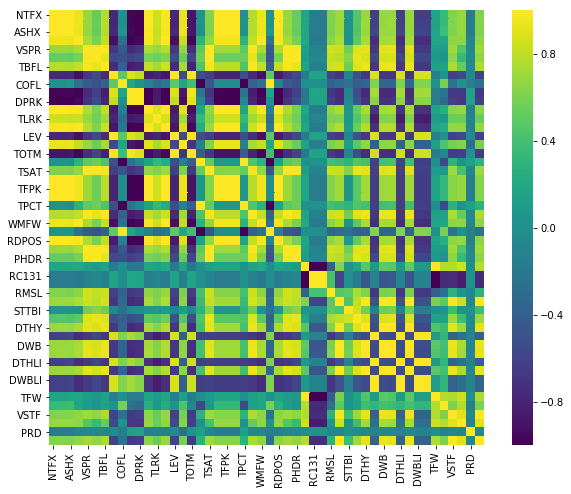

In [ ]:
df2=df.copy().set_index('TIME')
correlation_matrix = df2.corr()

print('Correlation matrix between the features')
plt.figure(1,figsize=(10,8))
ax=sns.heatmap(correlation_matrix, square=True, cmap ='viridis',vmax=1,vmin=-1)
plt.show()

#plt.figure(2,figsize=(300,300))
#ax=sns.clustermap(df2,cmap='viridis',robust=True)
#plt.show()

##**Preprocessing Data**


1.   **Define Function to be used for Temporalize, flatten and scale the data**


---





In [ ]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [ ]:
def flatten(X):
    #from sample x timesteps x features to sample x features for each timesteps
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    #Transforming scaler trained data to LSTM input
    for i in range(X.shape[0]):

        X[i, :, :] = scaler.transform(X[i, :, :])

    return Xhow

2.   **Remove Time Column and Categorical Column**


---




In [ ]:
# Remove time column, and the categorical columns
df = df.drop(['TIME'], axis=1)
input_X = df.loc[:, df.columns != 'PRD'].values  # converts the df to a numpy array
input_y = df['PRD'].values

n_features = input_X.shape[1]  # number of features

3.   **Split Train ( by target or not), Test, Valid ( by target or not)**


---


The goal of this program is to predict the PRD(Reactor Period)=9999 as target in the future by lookback at 5 data (equal as 5sec) before the events occur.  

In [ ]:
#Goal is to predict 9999 by lookback the previous timestep data

#drop temporalized lookback
lookback=5 # Equivalent to 5 sec of past data from nearby PRD=9999.
X, y = temporalize(X = input_X, y = input_y, lookback=lookback)

#split between test and train (9999 and not 9999)
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=100)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

X_train_y0 = X_train[y_train!=9999]
X_train_y1 = X_train[y_train==9999]

X_valid_y0 = X_valid[y_valid!=9999]
X_valid_y1 = X_valid[y_valid==9999]

4.  **Reshaping the splitted data set into 3D shape Array (sample x timesteps x features)**
---



In [ ]:
#reshaping the train and test data into 3D array (sample x timesteps x features)
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

5.   **Scaling Data by fitting it in Sklearn.StandardScaler**


---



In [ ]:
# Initialize a scaler using the training data
scaler = StandardScaler().fit(flatten(X_train_y0))

# Scaling whole X and Y set
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

*test the input for LSTM*

In [ ]:
'''
////Test: Check if the scaling is correct.////

The test succeeds if all the column means
and variances are 0 and 1, respectively, after
flattening.
'''

a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [-0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0. -0. -0. -0.  0.  0. -0.
  0. -0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0. -0. -0.  0. -0.  0.  0.
 -0. -0.  0. -0. -0.  0.  0. -0.  0. -0.  0.  0.  0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


## **LSTM Autoencoder training**

---



1.   **Autoencoder architecture initiation**


---

This code is where the user input how long the iteration time by seting the batch and epoch. The owner still can't figure out the best combination to archive model loss <1.

In [ ]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 91

epochs = 200
batch = 1000
lr = 0.0001

In [ ]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(1000, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(1000, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(1000, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(1000, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 1000)           4200000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 1000)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 1000)           8004000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 1000)           8004000   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 49)             49049     
Total params: 28,261,049
Trainable params: 28,261,049
Non-trainable params: 0
_______________________________________

2.   **Compile and fitting the data**


---

In [ ]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                                                epochs=epochs,
                                                batch_size=batch,
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 124 samples, validate on 33 samples
Epoch 1/200





 - 10s - loss: 0.8353 - val_loss: 1.0526
Epoch 2/200
 - 5s - loss: 0.8343 - val_loss: 1.0514
Epoch 3/200
 - 4s - loss: 0.8332 - val_loss: 1.0501
Epoch 4/200
 - 4s - loss: 0.8322 - val_loss: 1.0487
Epoch 5/200
 - 4s - loss: 0.8309 - val_loss: 1.0470
Epoch 6/200
 - 4s - loss: 0.8295 - val_loss: 1.0450
Epoch 7/200
 - 4s - loss: 0.8278 - val_loss: 1.0426
Epoch 8/200
 - 4s - loss: 0.8257 - val_loss: 1.0396
Epoch 9/200
 - 4s - loss: 0.8231 - val_loss: 1.0359
Epoch 10/200
 - 4s - loss: 0.8199 - val_loss: 1.0315
Epoch 11/200
 - 4s - loss: 0.8161 - val_loss: 1.0259
Epoch 12/200
 - 4s - loss: 0.8112 - val_loss: 1.0190
Epoch 13/200
 - 4s - loss: 0.8052 - val_loss: 1.0104
Epoch 14/200
 - 4s - loss: 0.7978 - val_loss: 0.9997
Epoch 15/200
 - 4s - loss: 0.7884 - val_loss: 0.9861
Epoch 16/200
 - 4s - loss: 0.7765 - val_loss: 0.9688
Epoch 17/200

3.   **Plot the model loss vs epoch and data point index scatter after reconstruction**


---

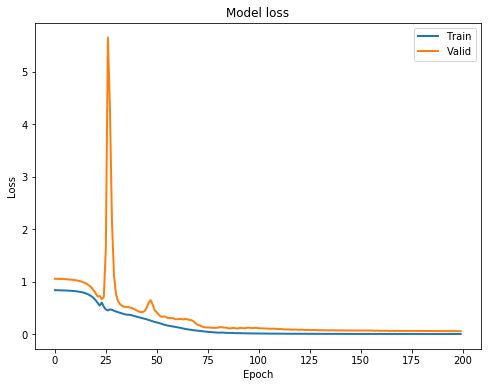

In [ ]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

3.   **Prediction using Autoencoder**


---

The proper way to visualize the data is still not found.
What the author knows is the prediction data is fit by the actual data behavior. Based on the plot behavior, the value of prediction a feature 46 (PRD) is representing the variance or (maybe) increement of the real value.



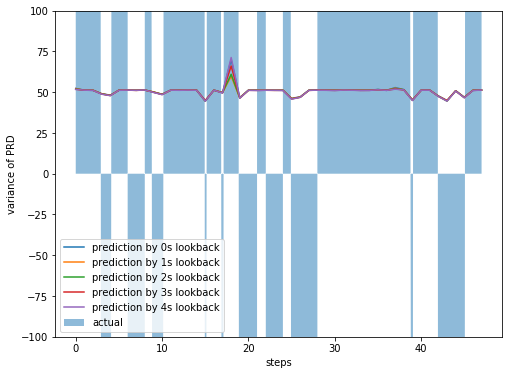

In [ ]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
valid_x_predictions=scaler.inverse_transform(valid_x_predictions)

aa=[x for x in range(len(valid_x_predictions[:,0]))]

plt.fill_between(aa,y_valid[:len(aa)],label='actual',alpha=0.5)
for n in range (0,5):
  plt.plot(aa,valid_x_predictions[:,n,46],label='prediction by {}s lookback'.format (n))
plt.ylim(-100,100)
plt.ylabel('variance of PRD')
plt.xlabel('steps')
plt.legend()
plt.show()

#Reference and Credits

---

This program is build with many listing and example from any other .ipynb scattered around internet. Here is some websites where the author gather the listing and knowledge



*   https://github.com/cran2367/lstm_autoencoder_classifier/blob/master/lstm_autoencoder_classifier.ipynb?source=post_page-----ce209a224cfb----------------------
*   https://blog.edugrad.com/forecasting-and-modeling-with-a-multivariate-time-series-in-python/
*   https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

